# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [158]:
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, lag
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.window import Window

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import re


In [41]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkifly Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [42]:
file = 'mini_sparkify_event_data.json'
df = spark.read.json(file)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [43]:
print('number of rows:' , df.count())

number of rows: 286500


In [44]:
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [46]:
# clean rows with empty userId
df = df.filter("userId <> ''")

In [49]:
df.select("userId").distinct().count()

225

In [51]:
userId_count_pd = df.groupby("userId").count().sort("count", ascending=[False]).toPandas()

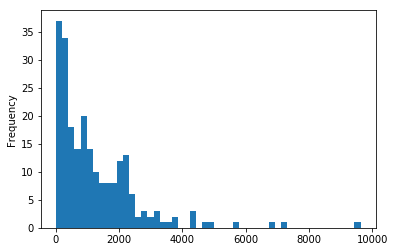

In [52]:
userId_count_pd['count'].plot(kind='hist', bins=50)

In [53]:
userId_count_pd.describe()

,count
count,225.000000
mean,1236.240000
std,1329.531716
min,6.000000
25%,296.000000
50%,848.000000
75%,1863.000000
max,9632.000000


In [54]:
userId_count_pd=None

In [55]:
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [56]:
df.select("page").distinct().show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [58]:
hasCancelled = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('Churn', hasCancelled(df['page']))

In [59]:
user_window = Window.partitionBy('userId')

df = df.withColumn('Churned', F.max('Churn').over(user_window))

In [60]:
df.select(['userId']).filter("Churn=1").distinct().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [177]:
print("total users churned",
      df.select(['userId']).filter("Churn=1").distinct().count())

total users churned 52


In [62]:
print('churn rate: ',52/226)

churn rate:  0.23008849557522124


In [63]:
df.select(["artist"]).distinct().count()

17656

In [178]:
df.filter("userId = '100010'").select(["userId", "page", "artist"]).sort(["ts"]).show()

+------+-----------+--------------------+
|userId|       page|              artist|
+------+-----------+--------------------+
|100010|   NextSong|Sleeping With Sirens|
|100010|   NextSong|Francesca Battist...|
|100010|   NextSong|              Brutha|
|100010|  Thumbs Up|                null|
|100010|   NextSong|         Josh Ritter|
|100010|   NextSong|               LMFAO|
|100010|   NextSong|         OneRepublic|
|100010|   NextSong|       Dwight Yoakam|
|100010|Roll Advert|                null|
|100010|   NextSong|      The Chordettes|
|100010|   NextSong|Coko featuring Ki...|
|100010|   NextSong|            The Cure|
|100010|Roll Advert|                null|
|100010|   NextSong|Kid Cudi Vs Crookers|
|100010|  Thumbs Up|                null|
|100010|   NextSong|            Yeasayer|
|100010|   NextSong|             Ben Lee|
|100010|Roll Advert|                null|
|100010|   NextSong|  ? & The Mysterians|
|100010|Roll Advert|                null|
+------+-----------+--------------

In [65]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df['ts']))

In [66]:
get_datetime = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.00)))
df = df.withColumn('log_datetime', get_datetime(df['ts']))

In [67]:
is_song = udf(lambda x: 1 if x=='NextSong' else 0)
df = df.withColumn('NextSong', is_song(df['page']))

In [68]:
has_paid= udf(lambda x: 1 if x=='paid' else 0) 
df = df.withColumn('hasPaid', has_paid('level'))

In [69]:
has_downgrade =  udf(lambda x: 1 if x=='downgrade' else 0, IntegerType()) 
df = df.withColumn('hasDowngrade', has_downgrade('page'))

In [70]:
df.filter("artist is not null").groupBy(["artist"]).count().sort('count', ascending=[False])\
    .withColumn('percent', F.col('count')/F.sum('count').over(Window.partitionBy())*100)\
    .withColumn('cum_percent', F.sum('percent').over(Window.partitionBy().orderBy().rowsBetween(Window.unboundedPreceding, 0)))\
    .show(1700)

+--------------------+-----+--------------------+------------------+
|              artist|count|             percent|       cum_percent|
+--------------------+-----+--------------------+------------------+
|       Kings Of Leon| 1841|   0.807073842215091| 0.807073842215091|
|            Coldplay| 1813|  0.7947989548810214|1.6018727970961124|
|Florence + The Ma...| 1236|   0.541848598032511|2.1437213951286234|
|       Dwight Yoakam| 1135|  0.4975713258631876| 2.641292720991811|
|            BjÃÂ¶rk| 1133|  0.4966945481964684|3.1379872691882795|
|      The Black Keys| 1125| 0.49318743752959127|3.6311747067178706|
|                Muse| 1090|  0.4778438283620039|4.1090185350798745|
|       Justin Bieber| 1044| 0.45767794202746065| 4.566696477107335|
|        Jack Johnson| 1007|  0.4414575551931541|  5.00815403230049|
|              Eminem|  953| 0.41778455819173377|5.4259385904922235|
|           Radiohead|  884|  0.3875357286899188| 5.813474319182142|
|     Alliance Ethnik|  876|  0.38

In [71]:
artist_no_churned = np.array(df.filter('artist is not null and Churned=0').select('artist').collect())
artist_no_churned = set(artist_no_churned.flatten())

artist_churned = np.array(df.filter('artist is not null and Churned=1').select('artist').collect())
artist_churned = set(artist_churned.flatten())

artist_only_churn = artist_churned - artist_no_churned
artist_only_no_churn = artist_no_churned - artist_churned

In [72]:
print('distinct artist: ',
      '17655')
      #df.filter('artist is not null').select('artist').distinct().count())

print('distinct artist in churned users: ',
      len(artist_churned))

print('distinct artist not churned users: ',
      len(artist_no_churned))

print('artist only in churned: ', 
      len(artist_churned - artist_no_churned))

print('artist only in not churned: ',
     len(artist_no_churned - artist_churned))

distinct artist:  17655
distinct artist in churned users:  8402
distinct artist not churned users:  16652
artist only in churned:  1003
artist only in not churned:  9253


In [73]:
df = df.withColumn('artist_only_churn', col('artist').isin(artist_only_churn).cast('integer'))
df = df.withColumn('artist_only_no_churn', col('artist').isin(artist_only_no_churn).cast('integer'))    

#### general info aggregated by userId

In [74]:
# general info aggregated by userId
user = df.groupBy("userId").agg(
    F.max('location').alias('max_location'),
    F.max('gender').alias('max_gender'),
    F.max('hasDowngrade').alias('max_hasDowngrade'),
    F.max('Churn').alias('max_churn'),
    F.collect_list("artist").alias("artist_list"),
    F.sum('artist_only_churn').alias("sum_artist_churn"),
    F.sum('artist_only_no_churn').alias('sum_artist_no_churn')
)

user.show(5)

+------+--------------------+----------+----------------+---------+--------------------+----------------+-------------------+
|userId|        max_location|max_gender|max_hasDowngrade|max_churn|         artist_list|sum_artist_churn|sum_artist_no_churn|
+------+--------------------+----------+----------------+---------+--------------------+----------------+-------------------+
|100010|Bridgeport-Stamfo...|         F|               0|        0|[Sleeping With Si...|               0|                 34|
|200002|Chicago-Napervill...|         M|               0|        0|[Eminem, This Is ...|               0|                 53|
|   125|  Corpus Christi, TX|         M|               0|        1|[Christopher O'Ri...|               0|                  0|
|   124|Vineland-Bridgeto...|         F|               0|        0|[The Crests, Chim...|               0|                461|
|    51|Lexington-Fayette...|         M|               0|        1|[Angus & Julia St...|              69|             

#### time between user sessions

In [75]:
# time between sessionsa

# rank in session
session_by_ts_win = Window.partitionBy(['userId','sessionId']).orderBy('ts')
df = df.withColumn('rank', F.rank().over(session_by_ts_win))

# time_diff
user_by_ts = Window.partitionBy(['userId']).orderBy('ts')
df = df.withColumn('ts_diff', col('ts') - F.lag('ts',1).over(user_by_ts))

# time diff between first page in current session - last page in previous session
time_btw_session = df.select(['userId','ts_diff'])\
                         .filter("rank=1 and ts_diff is not null")\
                         .groupBy('userId').agg(avg('ts_diff').alias('time_btw_sessions'))
time_btw_session.show()

+------+--------------------+
|userId|   time_btw_sessions|
+------+--------------------+
|100010|           5.36505E8|
|200002|           7.67004E8|
|   124|1.4400986206896552E8|
|    51|  9.33251111111111E7|
|     7|          7.251555E8|
|    15|3.0406771428571427E8|
|    54|          8.283875E7|
|   155|          4.068078E8|
|100014|           6.99396E8|
|   132|          2.589322E8|
|   154|         1.0694535E9|
|   101|  9.77648888888889E7|
|    11|       2.778219375E8|
|   138| 2.891484666666667E8|
|300017| 6.815283870967741E7|
|100021|         9.6573475E8|
|    29| 8.814070588235295E7|
|    69|         5.1510275E8|
|   112| 5.404053333333334E8|
|    42| 9.265778260869566E7|
+------+--------------------+
only showing top 20 rows



#### number of songs played, and number os sessions


In [76]:
# number of songs played, and number os sessions

song_session = df.groupBy(['userId','sessionId'])\
                .agg(
                    F.sum('length'), 
                    F.sum('NextSong')\
                )\
                .groupBy('userId')\
                .agg(
                    F.avg('sum(length)').alias("avg_session_length"),
                    F.avg('sum(NextSong)').alias("avg_session_songs"),
                    F.sum('sum(length)').alias("total_session_length"),   
                    F.sum('sum(NextSong)').alias("total_songs_played"),
                    F.count('sum(length)').alias("total_sessions")
                )

song_session.show()


+------+------------------+------------------+--------------------+------------------+--------------+
|userId|avg_session_length| avg_session_songs|total_session_length|total_songs_played|total_sessions|
+------+------------------+------------------+--------------------+------------------+--------------+
|100010| 9562.985335714286|39.285714285714285|         66940.89735|             275.0|             7|
|200002|15668.145989999992|              64.5|   94008.87593999995|             387.0|             6|
|   125|2089.1131000000005|               8.0|  2089.1131000000005|               8.0|             1|
|    51| 52327.58427999999|             211.1|  523275.84279999987|            2111.0|            10|
|   124|36154.003313928566| 140.6551724137931|  1012312.0927899998|            4079.0|            28|
|     7| 5433.441014285714|21.428571428571427|          38034.0871|             150.0|             7|
|    54|20324.140558285715| 76.78378378378379|        711344.91954|            284

### join aggregated columns

In [77]:
joined_df = None
joined_df = user.join(song_session, ["userId"], "inner")\
                .join(time_btw_session, ["userId"], "inner")

joined_df.show()

+------+--------------------+----------+----------------+---------+--------------------+----------------+-------------------+------------------+------------------+--------------------+------------------+--------------+--------------------+
|userId|        max_location|max_gender|max_hasDowngrade|max_churn|         artist_list|sum_artist_churn|sum_artist_no_churn|avg_session_length| avg_session_songs|total_session_length|total_songs_played|total_sessions|   time_btw_sessions|
+------+--------------------+----------+----------------+---------+--------------------+----------------+-------------------+------------------+------------------+--------------------+------------------+--------------+--------------------+
|100010|Bridgeport-Stamfo...|         F|               0|        0|[Sleeping With Si...|               0|                 34| 9562.985335714286|39.285714285714285|         66940.89735|             275.0|             7|           5.36505E8|
|200002|Chicago-Napervill...|         M|

In [179]:
user_pd = joined_df.toPandas()

In [182]:
user_pd.groupby('max_churn').mean()

,max_hasDowngrade,sum_artist_churn,sum_artist_no_churn,avg_session_length,avg_session_songs,total_session_length,total_songs_played,total_sessions,time_btw_sessions
max_churn,,,,,,,,,
0,0,0.000000,131.463415,18132.491619,70.911949,290287.935539,1164.829268,15.506098,5.207053e+08
1,0,23.347826,0.000000,16624.929701,64.868798,195489.245545,786.173913,11.152174,2.500782e+08


In [78]:
joined_df.count()

210

In [80]:
joined_df.write.parquet("joined_df2.parquet")

In [ ]:
"""
user_window = Window.partitionBy('userId')

df = df.withColumn('Churned', F.max('Churn').over(user_window))\
       .withColumn('n_sessions', F.approx_count_distinct('sessionId').over(user_window))\
       .withColumn('n_songs',F.sum('NextSong').over(user_window))


session_window = Window.partitionBy(['userId','sessionId'])

df = df.withColumn('song_per_session', F.sum('NextSong').over(session_window))\
       .withColumn('session_length', F.sum('length').over(session_window))

df.filter("userId='100005'").groupBy(['userId','sessionId']).agg({'song_per_session':'avg', 'session_length':'avg'}).show()

df.filter("userId='100005'").withColumn('song_per_session', F.count('NextSong').over(session_window))\
    .withColumn('session_length', F.sum('length').over(session_window))\
    .select("userId","sessionId","song_per_session","session_length","artist")\
    .show(300)

df.filter("userId='100005'").withColumn('rank', F.rank().over(session_by_ts_win))\
    .withColumn('lead_rank', F.lead('rank',1).over(session_by_ts_win))\
    .withColumn('ts_diff', col('ts') - F.lag('ts',1).over(user_by_ts))\
    .select("userId","sessionId",'rank','lead_rank','ts_diff')\
    .show(200)

df.select(["userId", "page","log_datetime","sessionId","Churned","n_sessions","n_songs","song_per_session","session_length"])\
.filter("userId ='100005'")\
.sort("ts").show(300)
"""


#TODO: filter out 0 sum and max sum to get more exact answer
""""
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()
"""


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [81]:
df2 = spark.read.parquet("joined_df2.parquet")

df2 = df2.withColumnRenamed('max_churn','label')


df2.printSchema()


root
 |-- userId: string (nullable = true)
 |-- max_location: string (nullable = true)
 |-- max_gender: string (nullable = true)
 |-- max_hasDowngrade: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- artist_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sum_artist_churn: long (nullable = true)
 |-- sum_artist_no_churn: long (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- avg_session_songs: double (nullable = true)
 |-- total_session_length: double (nullable = true)
 |-- total_songs_played: double (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- time_btw_sessions: double (nullable = true)



In [156]:
rest, validation = df2.randomSplit([0.9, 0.1], seed=42)

In [159]:
cv = CountVectorizer(inputCol="artist_list", outputCol="TF")
#idf = IDF(inputCol="TF", outputCol="features")


location_index = StringIndexer(inputCol='max_location', outputCol="location_index", handleInvalid='keep')
gender_index = StringIndexer(inputCol='max_gender', outputCol="gender_index")


numerical = ["max_hasDowngrade","sum_artist_churn","sum_artist_no_churn","avg_session_length",
             "avg_session_songs","total_session_length","total_songs_played","total_sessions","time_btw_sessions"]

#scaler
numfeatures = VectorAssembler(inputCols=numerical, outputCol='NumFeatures')
scaler = StandardScaler(inputCol='NumFeatures', outputCol="ScaledNumFeatures")#Normalizer(inputCol='NumFeatures', outputCol="ScaledNumFeatures")

assembler = VectorAssembler(inputCols=["TF",
                                       #"location_index",
                                       #"gender_index",
                                       "ScaledNumFeatures"
                                      ], 
                            outputCol='features')

lr =  RandomForestClassifier()#LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[cv, 
                            
                            #location_index, 
                            #gender_index,
                            
                            numfeatures, 
                            scaler, 
                            assembler,
                            
                            lr])

In [171]:
paramGrid = ParamGridBuilder() \
    .addGrid(cv.vocabSize,[1000, 2000]) \
    .build()
# .addGrid(lr.regParam,[0.0, 0.1]) \ #logistic regression

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=2)

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'MulticlassClassificationEvaluator' object has no attribute '_java_obj'


In [172]:
model = crossval.fit(rest)

In [173]:
model.avgMetrics

[0.7396627198462912, 0.7331446665304993]

In [174]:
for a, b in zip(model.avgMetrics, paramGrid):
    print (a, b)


0.7396627198462912 {Param(parent='CountVectorizer_d20fc9c58df4', name='vocabSize', doc='max size of the vocabulary. Default 1 << 18.'): 1000}
0.7331446665304993 {Param(parent='CountVectorizer_d20fc9c58df4', name='vocabSize', doc='max size of the vocabulary. Default 1 << 18.'): 2000}


In [175]:
results = model.transform(validation)

In [176]:
print(results.filter(results.label == results.prediction).count())
print(results.count())

18
23


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.